In [ ]:
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim 
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
DEVICE = torch.device('cuda')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
!unrar x "/content/drive/MyDrive/Colab Notebooks/data.rar"

In [ ]:
train_data = ImageFolder(r'/content/data/train', transform = transformations)
test_data = ImageFolder(r'/content/data/test', transform = transformations)


In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # (224,224)
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2)
        
        # (112,112)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        
        self.pool2 = nn.MaxPool2d(2)
        
        # (56,56)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        
        self.pool3 = nn.MaxPool2d(2)
        # (28,28)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128*28*28,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,1)
    
    def forward(self, x):
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = self.pool3(F.relu(self.conv3(out)))
        
        out = self.flatten(out)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        
        return out

In [ ]:
# Training loop for our network
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):
    max_acc=0
    max_epoch=0
    #Initializing two lists to save accuracy to plot them later
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    #Going thru every epoch
    for epoch in range(n_epochs):

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            output = model(example.float())
            # Getting loss of our network right now
            loss = loss_fn(output, labels.float())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
            
            
        with torch.no_grad():
            
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total
                
                  
        print(f'Epoch {epoch+1})', 
              f'Train Accuracy: {train_accuracy[epoch]}',
              f'Test Accuracy: {test_accuracy[epoch]}')

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(n_epochs)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        max_acc=torch.amax(test_accuracy)
        max_epoch=torch.argmax(test_accuracy)
        plt.plot(max_epoch,max_acc,'ro')
        plt.legend()
        plt.show()
        print(f'max test accuracy = {max_acc} in epoch = {max_epoch}')

In [ ]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle =True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle =True)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1) Train Accuracy: 0.8115282654762268 Test Accuracy: 0.8015151023864746
Epoch 2) Train Accuracy: 0.8206294775009155 Test Accuracy: 0.803030252456665
Epoch 3) Train Accuracy: 0.8771330714225769 Test Accuracy: 0.8378787636756897
Epoch 4) Train Accuracy: 0.8623435497283936 Test Accuracy: 0.8166666626930237
Epoch 5) Train Accuracy: 0.9245354533195496 Test Accuracy: 0.853030264377594
Epoch 6) Train Accuracy: 0.939704179763794 Test Accuracy: 0.8333333134651184
Epoch 7) Train Accuracy: 0.9632157683372498 Test Accuracy: 0.8439393639564514
Epoch 8) Train Accuracy: 0.981418251991272 Test Accuracy: 0.8454545140266418
Epoch 9) Train Accuracy: 0.9905195236206055 Test Accuracy: 0.8287878632545471
Epoch 10) Train Accuracy: 0.9897611141204834 Test Accuracy: 0.8348484635353088


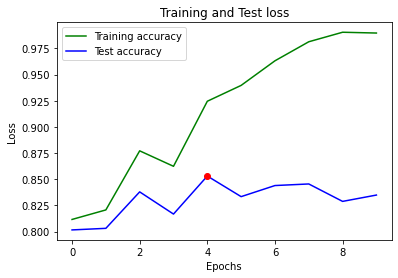

max test accuracy = 0.853030264377594 in epoch = 4


In [ ]:
learning_rate = 1e-3 # 0.001

model = Net().to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr = learning_rate)
loss_fn = nn.BCELoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True,
    train_loader = train_loader,
    test_loader = test_loader
)
